### Import data from postgres database on instance RDS (AWS)

In [28]:
from sqlalchemy import create_engine
import pandas as pd

# Conection to PostgreSQL in RDS
host = "disaster-tweets-db.cjkms2wu4u6j.eu-north-1.rds.amazonaws.com"
port = "5432"
database = "disaster-tweets-db"
user = "master"
password = "xxxxx"

# Create conection
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

# Load data from table
df = pd.read_sql_query("SELECT * FROM tweets_train_clean", con=engine)

# Check data from first rows
df.head()

,id,keyword,location,text,target,text_clean,text_len,word_count,text_lemmatized,keyword_clean,keyword_encoded,location_clean
0,1,no_keyword,unknown,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,68,13,our deed be the reason of this earthquake may ...,no keyword,147,unknown
1,4,no_keyword,unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,37,7,forest fire near la ronge sask canada,no keyword,147,unknown
2,5,no_keyword,unknown,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,130,22,all resident ask to shelter in place be be not...,no keyword,147,unknown
3,6,no_keyword,unknown,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,56,7,people receive wildfire evacuation order in ca...,no keyword,147,unknown
4,7,no_keyword,unknown,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,85,16,just got send this photo from ruby alaska as s...,no keyword,147,unknown


## Model 1 (Neural Network - multimode)

### Tokenize & Vectorize

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Define text and target fields
texts = df['text_lemmatized'].astype(str).tolist()  # Asegúrate de que son strings
labels = df['target'].tolist()

# 2. Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# 3. Padding (all sequences with same lenght)

# analysis to set maxlen in padded_sequences
lengths = df['text_lemmatized'].apply(lambda x: len(x.split()))
print(lengths.describe())
print(lengths.quantile([0.75, 0.90, 0.95, 0.99]))

padded_sequences = pad_sequences(sequences, padding='post', maxlen=33)

# 4. Verify with example
print("Ejemplo de tweet original:")
print(texts[0])
print("\nSecuencia tokenizada:")
print(sequences[0])
print("\nSecuencia con padding:")
print(padded_sequences[0])


count    7613.000000
mean       13.874557
std         5.994581
min         1.000000
25%         9.000000
50%        14.000000
75%        18.000000
max        33.000000
Name: text_lemmatized, dtype: float64
0.75    18.0
0.90    22.0
0.95    24.0
0.99    28.0
Name: text_lemmatized, dtype: float64
Ejemplo de tweet original:
our deed be the reason of this earthquake may allah forgive we all

Secuencia tokenizada:
[128, 3756, 3, 2, 549, 8, 22, 289, 152, 1437, 2142, 25, 43]

Secuencia con padding:
[ 128 3756    3    2  549    8   22  289  152 1437 2142   25   43    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [8]:
# saving tokenizer to apply it with test data

import pickle

with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# to import it again:
# with open("tokenizer.pickle", "rb") as handle:
#    tokenizer = pickle.load(handle)

### Other Features: normalize & concatenate them

In [44]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select othe numeric columns & concatenate them in a list
X_meta_raw = df[['text_len', 'word_count', 'keyword_encoded']].values

# Normalize
scaler = MinMaxScaler()
X_meta = scaler.fit_transform(X_meta_raw)

# Check shape and first rows
print(X_meta.shape)
print(X_meta[:5])

(7613, 3)
[[0.45454545 0.375      0.66515837]
 [0.23776224 0.1875     0.66515837]
 [0.88811189 0.65625    0.66515837]
 [0.37062937 0.1875     0.66515837]
 [0.57342657 0.46875    0.66515837]]


#### We have 3 data lists/matrix to feed our model:

* padded_sequences → vectorize text sequences (shape: [n_samples, 33])
* X_meta → normalize numeric features (text_len, word_count, keyword_encoded) → (shape: [n_samples, 3])
* labels → target vector (0 or 1) (shape: [n_samples])

### Divide training/test

In [56]:
from sklearn.model_selection import train_test_split

# Divide data
X_text_train, X_text_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    padded_sequences,
    X_meta,
    labels,
    test_size=0.2,
    random_state=42
)

In [57]:
# transform to numpy arrays that Keras needs as suitable inputs

X_text_train = np.array(X_text_train)
X_meta_train = np.array(X_meta_train)
y_train = np.array(y_train)

X_text_test = np.array(X_text_test)
X_meta_test = np.array(X_meta_test)
y_test = np.array(y_test)

print("X_text_train:", X_text_train.shape)
print("X_meta_train:", X_meta_train.shape)
print("y_train:", y_train.shape)

X_text_train: (6090, 33)
X_meta_train: (6090, 3)
y_train: (6090,)


### Model definition/structure

- problem definition -> binary classification (tweet about natural disaster or no ?)
- available input data -> tweet text after lemmatize & tokenize & vectorize + 3 numeric variables (X_meta)

model structure to build:
1. Embeddings + LSTM → to understand sequential texts from tweets (Transformers (BERT...) would be another option).
2. Denses over metadata → because X_meta contains flat numeric data (Decision Tree, XGBoost... would be options in ML models).
3. Concatenate → because both data sources provide value.
4. Output with sigmoid → because it's a binary classification.

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, GlobalAveragePooling1D
from tensorflow.keras import regularizers # add L2 regularization technic to penalize overlearning/overfitting 

# Key parameters
vocab_size = 10000 # total different possible words
embedding_dim = 128
maxlen = 33

# Input 1: Text
text_input = Input(shape=(maxlen,), name="text_input") # define fixed size input, each input is a text/tweet and each element a word/token as a number

  # transform each token in a dense vector with dimension = embedding_dim -> result: a matrix with dimension (maxlen, embedding_dim) per tweet/input
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(text_input) 

  # Long Short-Term Memory -> processvector sequences word by word, catch temporal dependencies and context; return all sequence per token, not only last state
x = LSTM(32, return_sequences=True)(x) 

  # summarize the sequence calculating all vectors (from LSTM output) average
x = GlobalAveragePooling1D()(x)

# Input 2: Metadata
meta_input = Input(shape=(3,), name="meta_input") # defined input with 3 values/columns (X_meta)
m = Dense(16, activation='relu')(meta_input) # give learnable representation; ReLu suitable for hidden layers: fast and avoids gradient descent

# Concatenate
combined = Concatenate()([x, m])
z = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined) # hidden layer for learning nonlinear combinations
z = Dropout(0.3)(z) # regularization, randomly turns off half of the neurons to avoid overfitting
z = Dense(1, activation='sigmoid')(z) # output layer, returns a value between 0 and 1 → probability that it is a disaster; Sigmoid suitable for binary
# classification (provides probability between 0 and 1)

# Model
model = Model(inputs=[text_input, meta_input], outputs=z)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# loss function would be "categorical_crossentropy" if task is multiclass classification, or MSE/MAE/... if task is regression
# optimizer Adam is common: fast, strong, stable with many parameters, etc...

model.summary()

C:\Users\Eros\anaconda3\envs\tfmodel\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 33)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 33, 128)           │       1,280,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 33, 32)            │          20,608 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ meta_input (InputLayer)       │ (None, 3)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 32)                │               0 │ lstm[0][0]                 │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 16)                │              64 │ meta_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 48)                │               0 │ global_average_pooling1d[… │
│                               │                           │                 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 16)                │             784 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 16)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              17 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,301,473 (4.96 MB)

 Trainable params: 1,301,473 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

### Training

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6172 - loss: 0.6645 - val_accuracy: 0.7991 - val_loss: 0.4853
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8568 - loss: 0.3983 - val_accuracy: 0.8076 - val_loss: 0.4574
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9112 - loss: 0.2781 - val_accuracy: 0.7932 - val_loss: 0.5113
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9422 - loss: 0.2060 - val_accuracy: 0.7932 - val_loss: 0.5813
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9592 - loss: 0.1535 - val_accuracy: 0.7866 - val_loss: 0.6666


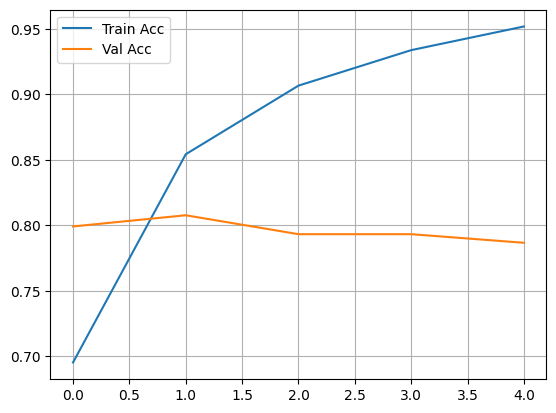

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

# to end training when model stops improving in validation
# with "patient" waits X EPOCHS without improving before stop it
# with "restore_best_weights"  = True -> it comes back to the model at better EPOCH
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    [X_text_train, X_meta_train],
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(
        {'text_input': X_text_test, 'meta_input': X_meta_test},
        y_test
    ),
    callbacks=[early_stop]
)

# batch_size:
#  - small size (8-32) generalize better but slower, more noise at gradient (it could help to escape from local minimums)
#  - big size (64-256) more stable and faster by EPOCH, but more overfitting or stay at local minimums
# high accuracy + low loss at training BUT low/similar val_accuracy + high/similar val_loss -> OVERFITTING
# note: 191/191 comes from 6100 training rows / 32 (batch size) = 191 batches

# Plot
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.grid()
plt.show()

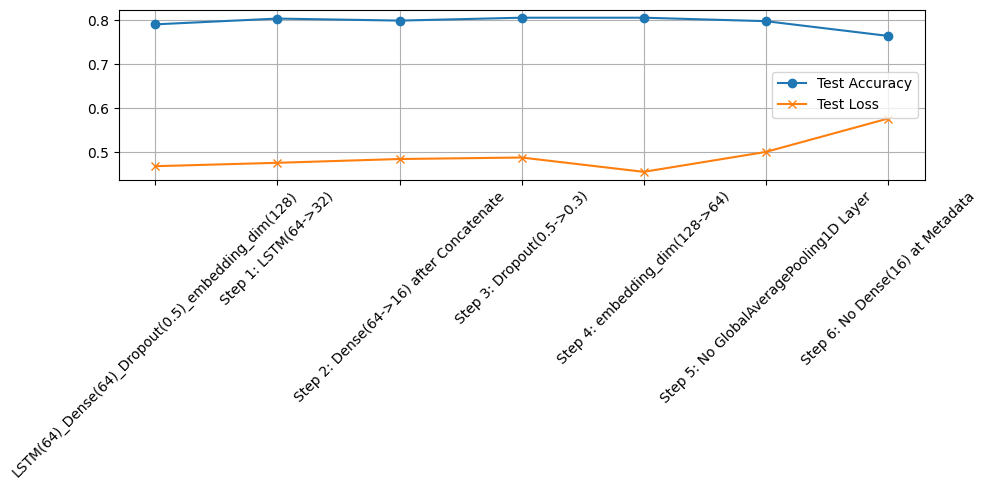

In [80]:
# Create a list to save results
# results = [] # comment after first append

# Evaluate model with test data after training it:
loss, accuracy = model.evaluate([X_text_test, X_meta_test], y_test, verbose=0)

# Save results
results.append({
    "test_accuracy": accuracy,
    "test_loss": loss,
    "modelo": "Step 6: No Dense(16) at Metadata" # LSTM(64)_Dense(64)_Dropout(0.5)_embedding_dim(128) 
})

# From list to dataframe
df_results = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_results["test_accuracy"], marker='o', label="Test Accuracy")
plt.plot(df_results["test_loss"], marker='x', label="Test Loss")
plt.xticks(range(len(df_results)), df_results["modelo"], rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [73]:
# IMPORTANT: SAVE MODEL WITH BEST PERFORMANCE TO APPLY IT LATER (WITH TEST DATA)
model.save("best_multimodal_model.keras") # run this when structure model is defined with best val_accuracy

# to import it later:
#from tensorflow.keras.models import load_model
#model = load_model("best_multimodal_model_step3")

In [92]:
print(df_results)
# analysing results we decide to apply changes (to reduce overfitting) until step 4, when better test_accuracy is obtained

df_results.to_csv("model_results_nn.csv", index=False)

   test_accuracy  test_loss                                             modelo
0       0.790545   0.468056  LSTM(64)_Dense(64)_Dropout(0.5)_embedding_dim(...
1       0.803677   0.475768                               Step 1: LSTM(64->32)
2       0.799081   0.484392            Step 2: Dense(64->16) after Concatenate
3       0.805647   0.487763                          Step 3: Dropout(0.5->0.3)
4       0.805647   0.455193                     Step 4: embedding_dim(128->64)
5       0.797768   0.500491            Step 5: No GlobalAveragePooling1D Layer
6       0.764281   0.576288                   Step 6: No Dense(16) at Metadata


In [95]:
# in addition to exporting locally to csv format, we'll upload to a new table at RDS database (AWS)
# we define a function to apply that upload because we'll use many more times

def upload_to_rds(df, table_name):
    df.to_sql(table_name, con=engine, index=False, if_exists="replace")

upload_to_rds(df_results, "model_results_nn")

#### Confusion Matrix & Classification Report from Choosen/Best Model

In [47]:
# PREVIOUS REPEATED CODE
# we have to re-create/re-define needed data (not saved at memory) to apply choosen/best model
# after importing data from database at RDS (AWS), we have to apply same saved tokenizer & model (creating val_dataset that was not saved in memory)

# import saved tokenizer (same used to obtained choosen/best model) and recalculate padded_sequences to get exact ones we got with same tokenizer
import pickle
with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

from tensorflow.keras.preprocessing.sequence import pad_sequences
labels = df['target'].tolist()
texts = df['text_lemmatized'].astype(str).tolist()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=33)

# IMPORTANT -> X_meta can be get running same defined cell at the begining of the code, with no changes; labels is calculating again here with a single
# code line, and padded_sequences is the required input to the model that must be got applying saved tokenizer, with these code lines above
# After this, it must be executed same previous code to split into train/test

In [99]:
# NEW CODE

# 1 - Import saved best model
from tensorflow import keras
model = keras.models.load_model("best_multimodal_model.keras")

# 2 - Get predictions on the validation dataset
pred_probs = model.predict([X_text_test, X_meta_test])
y_pred = (pred_probs > 0.5).astype(int).flatten()

# 3 - Real labels -> we got them at y_test

# 4 - New evaluation metrics & export
from sklearn.metrics import classification_report, confusion_matrix

cm_nn = confusion_matrix(y_test, y_pred)
df_cm_nn = pd.DataFrame(cm_nn).rename(columns={'0': 'class 0 - no disaster', '1': 'class 1 - disaster'})
df_cm_nn["actual_class"] = ["class 0 - no disaster", "class 1 - disaster"]
df_cm_nn.to_csv("confusion_matrix__nn_model.csv", index=False)
print("Confusion Matrix:\n", cm_nn)

report_nn = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report_nn).transpose().to_csv("classification_report__nn_model.csv")
print("\nClassification Report:\n", report_nn)

# 5 - upload to RDS
upload_to_rds(df_cm_nn, "confusion_matrix__nn_model")
upload_to_rds(pd.DataFrame(report_nn).transpose(), "classification_report__nn_model")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Confusion Matrix:
 [[733 121]
 [175 494]]

Classification Report:
 {'0': {'precision': 0.8072687224669604, 'recall': 0.8583138173302107, 'f1-score': 0.8320090805902384, 'support': 854}, '1': {'precision': 0.8032520325203252, 'recall': 0.7384155455904334, 'f1-score': 0.7694704049844235, 'support': 669}, 'accuracy': 0.8056467498358503, 'macro avg': {'precision': 0.8052603774936428, 'recall': 0.798364681460322, 'f1-score': 0.800739742787331, 'support': 1523}, 'weighted avg': {'precision': 0.8055043327267772, 'recall': 0.8056467498358503, 'f1-score': 0.8045380536826283, 'support': 1523}}


## Model 2 (Transformers)

#### Tokenize

In [7]:
import numpy as np
from transformers import DistilBertTokenizerFast

# pre-trained tokenizer with big corpus that recognize words, sub-words, symbols... not based on our texts/tweets
# it provides vectors with ids + mask tknow parts of the text to import (all required by this specific model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(
    df["text_lemmatized"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="tf"  # or "pt" if applying PyTorch
)

# transform tensors to numpy_arrays because train/test_split will need that format/type
input_ids_np = encodings['input_ids'].numpy()
attention_mask_np = encodings['attention_mask'].numpy()

# prepare labels as numpy array or tensor
labels = np.array(df["target"])

In [50]:
# saving tokenizer to apply it with test data (submission)

tokenizer.save_pretrained("best_transformer_model_tokenizer")

# to import it again:
# from transformers import DistilBertTokenizer
# tokenizer = DistilBertTokenizer.from_pretrained("best_transformer_model_tokenizer")

('best_transformer_model_tokenizer\\tokenizer_config.json',
 'best_transformer_model_tokenizer\\special_tokens_map.json',
 'best_transformer_model_tokenizer\\vocab.txt',
 'best_transformer_model_tokenizer\\added_tokens.json',
 'best_transformer_model_tokenizer\\tokenizer.json')

#### Imports

In [2]:
from transformers import TFDistilBertForSequenceClassification, TFBertForSequenceClassification
from transformers import DistilBertTokenizerFast
from transformers import create_optimizer
import tensorflow as tf
from tf_keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

C:\Users\Eros\anaconda3\envs\tfmodel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Model definition & compile

In [10]:
# TFDistilBertForSequenceClassification is a pre-trained model from DistilBERT type, but adapted to text classification
# DistilBERT is a softer/faster version from BERT, keeping most of the performance
# It adds to BERT model a linear dense layer at the end that provide logits which are transformed to probabilities (with a sigmoid function)

model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
#model = TFBertForSequenceClassification.from_pretrained(
#    "bert-base-uncased", # more powerful/heavy than distilbert-base-uncased, but slower & more parameters
    num_labels=2,  # Binary clasification
    problem_type="single_label_classification"
)

# Freeze all layers (BERT backbone) except last one -> usefull when small dataset
#for layer in model.layers:
#    layer.trainable = False
#model.classifier.trainable = True  # only classification layer

# eficient/common optimizer used for NLP with transformers, with a standard value of learning_rate; it adjusts model weights
optimizer = Adam(learning_rate=1e-5) # decreasing e_rate 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy'] # to value performance

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# an error is got when loss=model.compute_loss because it's an internal function from Hugging Face model (to use it with own class "Trainer"), it doesn't
# fit ok with model.fit() from Keras (from TensorFlow), so when model.fit() tried to calculate loss with that function, it didn't find labels ok or it
# process them wrongly... Soooo, we use this explicit loss function "SparseCategoricalCrossentropy", compatible with Keras, suitable for multilabel
# classification with integers labels (0/1 this case)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

#### Prepare data

In [8]:
from sklearn.model_selection import train_test_split

# split train/test: divide input_ids, attention_mask and labels
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids_np,
    attention_mask_np,
    labels,
    test_size=0.2,
    random_state=42
)

# prepare data for training with transformer model, packaging as a tf.data.Dataset, both train and test parts
# it contains a tuple that consist of a dictionary with "input_ids" (text tokens array) and "attention mask" (marks if token is valid(invalid),
# and the label of this text/tweet... f.e.:
'''
(
  {
    'input_ids': [101, 2256, 15046, ..., 0, 0, 0],
    'attention_mask': [1, 1, 1, ..., 0, 0, 0]
  },
  1  # or 0
)
'''

# convert labels to int32 to be suitable to model
train_labels = train_labels.astype("int32")
val_labels = val_labels.astype("int32")

# training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    {
        'input_ids': train_inputs,
        'attention_mask': train_masks,
        'labels': train_labels
    }    
).shuffle(len(train_labels)).batch(16)

# validation dataset 
val_dataset = tf.data.Dataset.from_tensor_slices(
    {
        'input_ids': val_inputs,
        'attention_mask': val_masks,
        'labels': val_labels
    }
).batch(16)

#### Training

Epoch 1/3


381/381 [==============================] - 520s 1s/step - loss: 0.4576 - accuracy: 0.8016 - val_loss: 0.4096 - val_accuracy: 0.8286
Epoch 2/3
381/381 [==============================] - 502s 1s/step - loss: 0.3469 - accuracy: 0.8619 - val_loss: 0.4102 - val_accuracy: 0.8339
Epoch 3/3
381/381 [==============================] - 502s 1s/step - loss: 0.2828 - accuracy: 0.8936 - val_loss: 0.4186 - val_accuracy: 0.8234


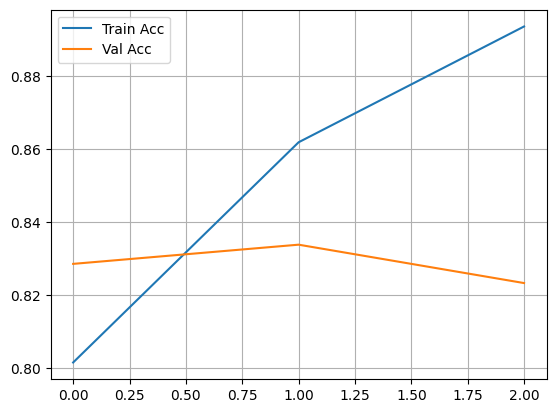

In [11]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    verbose=1 # show progress bar and metrics
)

# Plot
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.grid()
plt.show()

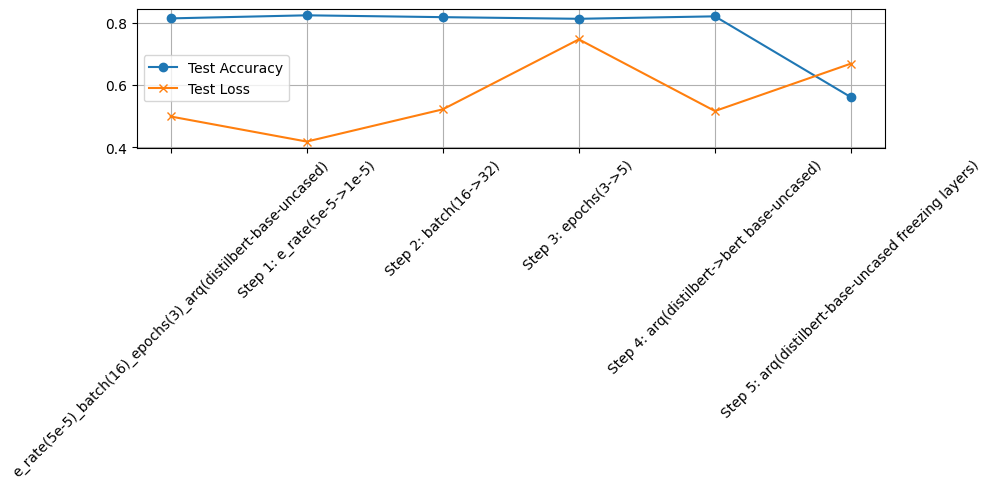

In [41]:
# Create a list to save results
#results_Transformers = [] # comment after first append

# Evaluate model with test data after training it:
loss, accuracy = model.evaluate(val_dataset)

# Save results
results_Transformers.append({
    "test_accuracy": accuracy,
    "test_loss": loss,
    "modelo": "Step 1: e_rate(5e-5->1e-5)" # e_rate(5e-5)_batch(16)_epochs(3)_arq(distilbert-base-uncased)   
})

# From list to dataframe
df_results_Transformers = pd.DataFrame(results_Transformers)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df_results_Transformers["test_accuracy"], marker='o', label="Test Accuracy")
plt.plot(df_results_Transformers["test_loss"], marker='x', label="Test Loss")
plt.xticks(range(len(df_results_Transformers)), df_results_Transformers["modelo"], rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [12]:
# IMPORTANT: SAVE MODEL WITH BEST PERFORMANCE TO APPLY IT LATER (WITH TEST DATA)
model.save_pretrained("best_transformer_model") # run this when structure model is defined with best val_accuracy

# to import it later:
#from transformers import TFDistilBertForSequenceClassification
#model = TFDistilBertForSequenceClassification.from_pretrained("best_transformer_model")

In [103]:
print(df_results_Transformers)
# analysing results we decide to apply changes (to reduce overfitting) until step 1, when better test_accuracy is obtained

df_results_Transformers.to_csv("model_results_transformers.csv", index=False) # export to csv
upload_to_rds(df_results_Transformers, "model_results_transformers") # upload to rds

   test_accuracy  test_loss                                             modelo
0       0.813526   0.499005  e_rate(5e-5)_batch(16)_epochs(3)_arq(distilber...
1       0.823375   0.418623                         Step 1: e_rate(5e-5->1e-5)
2       0.817466   0.521976                              Step 2: batch(16->32)
3       0.812213   0.746268                               Step 3: epochs(3->5)
4       0.820092   0.516525         Step 4: arq(distilbert->bert base-uncased)
5       0.560735   0.668573  Step 5: arq(distilbert-base-uncased freezing l...


#### Confusion Matrix & Classification Report from Choosen/Best Model

In [5]:
# PREVIOUS REPEATED CODE
# we have to re-create/re-define needed data (not saved at memory) to apply choosen/best model
# after importing data from database at RDS (AWS), we have to apply same saved tokenizer & model (creating val_dataset that was not saved in memory)

# import saved tokenizer (same used to obtained choosen/best model)
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("best_transformer_model_tokenizer")

# apply tokenizer to imported original data
import numpy as np
encodings = tokenizer(df["text_lemmatized"].tolist(), truncation=True, padding=True, max_length=128, return_tensors="tf")
input_ids_np = encodings['input_ids'].numpy() # transform tensors to numpy_arrays because train/test_split will need that format/type
attention_mask_np = encodings['attention_mask'].numpy() # transform tensors to numpy_arrays because train/test_split will need that format/type
labels = np.array(df["target"]) # prepare labels as numpy array or tensor

# split train/test: divide input_ids, attention_mask and labels
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids_np,
    attention_mask_np,
    labels,
    test_size=0.2,
    random_state=42
)

val_labels = val_labels.astype("int32") # convert labels to int32 to be suitable to model
val_dataset = tf.data.Dataset.from_tensor_slices({'input_ids': val_inputs, 'attention_mask': val_masks, 'labels': val_labels}).batch(16) # validation dataset

In [104]:
# NEW CODE

# 1 - Import saved best model
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained("best_transformer_model")

# 2 - Get predictions on the validation dataset
pred_logits = model.predict(val_dataset) # get predictions in logits shape
pred_classes = np.argmax(pred_logits.logits, axis=1) # convert logits on classes (0 or 1)

# 3 - Real labels -> we got them at val_labels

# 4 - New evaluation metrics & export
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(val_labels, pred_classes) # confusion matrix
print("Confusion Matrix:\n", cm)
cm_df = pd.DataFrame(cm, columns=["Pred_0", "Pred_1"])
cm_df["actual_class"] = ["class 0 - no disaster", "class 1 - disaster"]
cm_df.to_csv("confusion_matrix__transformers_model.csv", index=True)

report_dict = classification_report(val_labels, pred_classes, digits=4, output_dict=True) # complete report
print("\nClassification Report:\n", report_dict)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("classification_report__transformers_model.csv", index=True)

# 5 - upload to RDS
upload_to_rds(cm_df, "confusion_matrix__transformers_model")
upload_to_rds(report_df, "classification_report__transformers_model")

Some layers from the model checkpoint at best_transformer_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at best_transformer_model and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


96/96 [==============================] - 27s 269ms/step
Confusion Matrix:
 [[753 101]
 [168 501]]

Classification Report:
 {'0': {'precision': 0.8175895765472313, 'recall': 0.8817330210772834, 'f1-score': 0.8484507042253521, 'support': 854}, '1': {'precision': 0.8322259136212624, 'recall': 0.7488789237668162, 'f1-score': 0.7883556254917388, 'support': 669}, 'accuracy': 0.8233749179251477, 'macro avg': {'precision': 0.8249077450842468, 'recall': 0.8153059724220497, 'f1-score': 0.8184031648585455, 'support': 1523}, 'weighted avg': {'precision': 0.8240188014339856, 'recall': 0.8233749179251477, 'f1-score': 0.8220530629431543, 'support': 1523}}


### SUBMISSION

In [115]:
# we apply best model (with transformers) to tweets from test.csv to generate submission that will be uploaded to Kaggle

# 1 - download test tweets to predict
df_test = pd.read_sql("SELECT * FROM tweets_test_clean", engine)

# 2 - apply saved tokenizer
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("best_transformer_model_tokenizer")
encodings_test = tokenizer(df_test["text_lemmatized"].tolist(), truncation=True, padding=True, max_length=128, return_tensors="tf")
input_ids_test = encodings_test["input_ids"]
attention_mask_test = encodings_test["attention_mask"]

# 3 - load saved model
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained("best_transformer_model")

# 4 - create predictions
import numpy as np
outputs = model.predict({"input_ids": input_ids_test, "attention_mask": attention_mask_test}) # get predictions from model
y_pred = np.argmax(outputs.logits, axis=1) # logits to labels 0/1

# 5 - save predictions
submission_df = pd.DataFrame({"id": df_test["id"], "target": y_pred})
submission_df.to_csv("submission.csv", index=False)
upload_to_rds(submission_df, "submission_to_kaggle")

Some layers from the model checkpoint at best_transformer_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at best_transformer_model and are newly initialized: ['dropout_159']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


102/102 [==============================] - 70s 676ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

#### Check tables at database in RDS instance (AWS)

In [29]:
# check table has been created and its content
from sqlalchemy import inspect
inspector = inspect(engine) # Check if new table is defined at database in RDS instance
print(inspector.get_table_names())
df_check_test = pd.read_sql('SELECT * FROM classification_report__transformers_model LIMIT 10', con=engine)
df_check_test.head()

['models_results_output_Prep', 'tweets_train', 'tweets_test', 'tweets_submission', 'confusion_matrix__nn_model', 'confusion_matrix__transformers_model', 'classification_report__transformers_model', 'tweets_train_clean', 'tweets_test_clean', 'classification_reports_output_Prep', 'model_results_nn', 'model_results_transformers', 'confusion_matrix_output_Prep', 'submission_to_kaggle', 'classification_report__nn_model']


,Unnamed: 0,precision,recall,f1-score,support
0,0,0.817590,0.881733,0.848451,854.000000
1,1,0.832226,0.748879,0.788356,669.000000
2,accuracy,0.823375,0.823375,0.823375,0.823375
3,macro avg,0.824908,0.815306,0.818403,1523.000000
4,weighted avg,0.824019,0.823375,0.822053,1523.000000
